GitHub: https://github.com/MYUSER/MYPROJECT/

Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.


Let's get started! Run the following cell to install all the packages you will need.


In [1]:
#!pip install numpy
#!pip install matplotlib
#!pip install lime
#!pip install shap
#!pip install sklearn
#!pip install xgboost
#!pip install graphviz
#!pip install pydot
#!pip install pydotplus
#!pip install seaborn


Run the following cell to load the packages you will need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [3]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [4]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
print(mapping)
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(3)

{'Workclass': {0: ' ?', 1: ' Federal-gov', 2: ' Local-gov', 3: ' Never-worked', 4: ' Private', 5: ' Self-emp-inc', 6: ' Self-emp-not-inc', 7: ' State-gov', 8: ' Without-pay'}, 'Marital Status': {0: ' Divorced', 1: ' Married-AF-spouse', 2: ' Married-civ-spouse', 3: ' Married-spouse-absent', 4: ' Never-married', 5: ' Separated', 6: ' Widowed'}, 'Occupation': {0: ' ?', 1: ' Adm-clerical', 2: ' Armed-Forces', 3: ' Craft-repair', 4: ' Exec-managerial', 5: ' Farming-fishing', 6: ' Handlers-cleaners', 7: ' Machine-op-inspct', 8: ' Other-service', 9: ' Priv-house-serv', 10: ' Prof-specialty', 11: ' Protective-serv', 12: ' Sales', 13: ' Tech-support', 14: ' Transport-moving'}, 'Relationship': {0: ' Husband', 1: ' Not-in-family', 2: ' Other-relative', 3: ' Own-child', 4: ' Unmarried', 5: ' Wife'}, 'Race': {0: ' Amer-Indian-Eskimo', 1: ' Asian-Pac-Islander', 2: ' Black', 3: ' Other', 4: ' White'}, 'Sex': {0: ' Female', 1: ' Male'}, 'Country': {0: ' ?', 1: ' Cambodia', 2: ' Canada', 3: ' China', 4

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

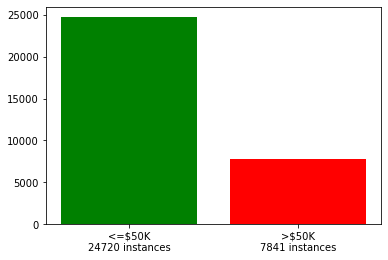

In [5]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)


The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [7]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [8]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [9]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7417
           1       0.67      0.60      0.64      2352

    accuracy                           0.83      9769
   macro avg       0.78      0.76      0.76      9769
weighted avg       0.83      0.83      0.83      9769



To get more details, let's print the confusion matrix:

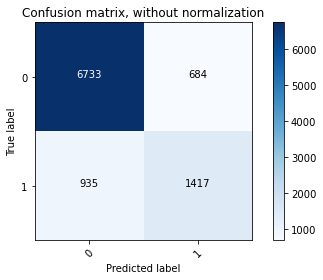

In [10]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

***

**Task 1**: Please provide comments on the performance of the classifier.

***

<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<h3>Post-modelling Explainability - Performance - Verbal Explaination:</h3>
<p style="fontsize:80px">

<br>
Definitions:
<br>
Confusion Matrix - Confusion matrix is a 2D table of prediction counts of true class labels vs predicted class labels.<br>

|  | Actual Positive | Actual Negative |
| --------- | ----------- | -------- |
| Predicted Positive | True Positive(TP) | False Positive(FP) |
| Predicted Negative | False Negative(FN) | True Negative(TN) |

<br>
Accuracy Score - TP+TN / (TP+TN+FP+FN)<br>
Precision - TP / TP+FP<br>
Recall - TP / TP+FN<br>
F1 - 2 * (Precision * recall) / Precision + recall  
    <br>  
    <br>  
Interpretation:    
    <br>
- As per the confusion matrix, 8150 records were classified correctly and 1619 records were misclassified.   
    <br>
- According to classification report, accuracy achieved by classifier was 83.00 %. However, as we see from statistical plot in preprocessing section that classes in our dataset are highly imbalanced. We cannot count on accuracy score alone for judging performance of the model. We also need to take into consideration precision and recall scores. F1 score is harmonic mean of precision and recall and gives equal importance to both. F1 score for XGB classifier trained above is 83.09 %.   
    <br>  
    <br>  
The performance of the model can be further improved by implementing following things:<br>
1. In preprocessing use OneHotEncoding (binary) rather than LabelEncoding(integers) as integer encoding has sequence which might mislead model  
    <br>
2. Standardize / Normalize the data.  
    <br>
3. Tune hyperparameters of the XGB classifier.  
    <br>
</p>
</div>

# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

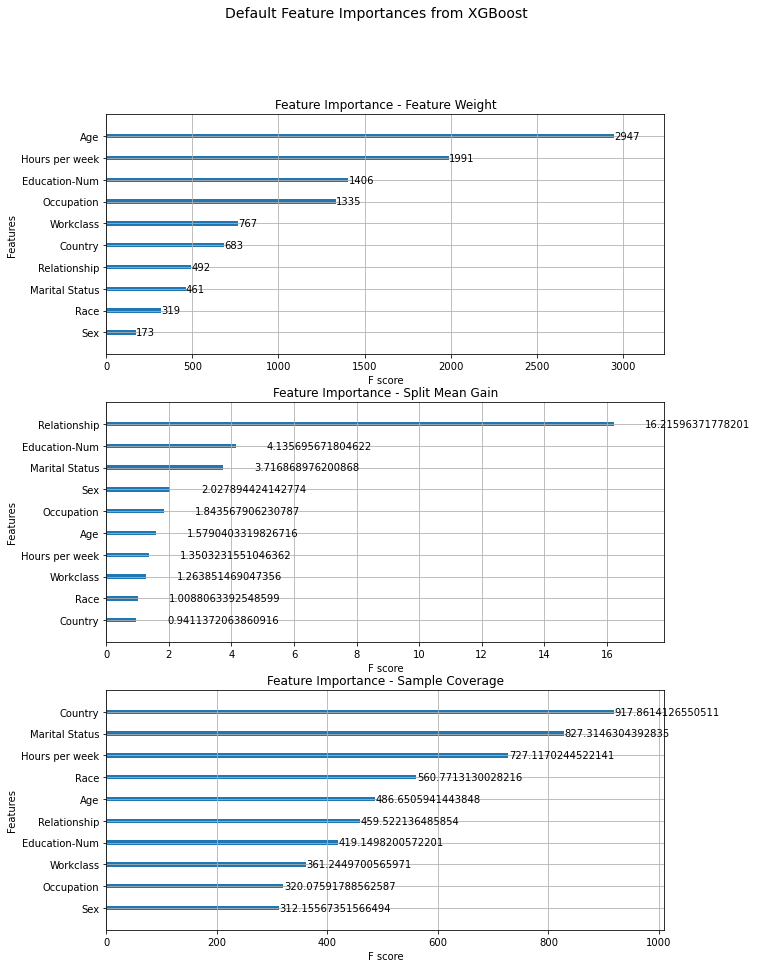

In [11]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.

***

<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<h3>Pre-modelling Explainability - Feature Engineering - Verbal Explaination:</h3>
<p style="fontsize:80px">

<br>
Definitions:  
    <br>
Global feature importance: Feature importance that is calculated based on entire dataset and over entire ensemble of models.  <br>  

Before interpreting results lets understand what each feature importance criteria in XGBoost is  
    <br>  
- Feature Weight: It is count of times the feature is used in all generated trees.  
    <br>
- Gain: Gain is the improvement in accuracy by relative contribution of the feature for each tree in the XGBoost model.  
    <br>
- Coverage: Number of times the feature is used in observations to decide leaf node.  
    <br>  
    <br>  
Interpretation:  
    <br>
We calculated feature importance of dataset using weight, gain, coverage metrics.  
    <br>
- As per Feature Weight metric, where all the features are arranged in descending order of thier scores, Age has the highest importance while sex has least importance.  
    <br>
- As per Gain metric, where all the features are arranged in descending order of thier scores, relationship has highest importance and country has least importance.  
    <br>
- As per coverage metric, where all the features are arranged in descending order of thier scores, country has highest importance and sex has least importance.  
    <br>  
    <br>  
If the data is not standardized, Weight and coverage are prone to punish features having less possible values like 'sex' in above example. Thus, for our dataset feature importance with Gain metric would be most viable option.  
       <br>  
    <br>  
</p>
</div>

# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [12]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5, objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [13]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [14]:
a = np.where(predictions == 0)
b = np.where(y_test == 0)
np.intersect1d(a,b)

# Change only the value of to select that person:
i = 2
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")


Intercept 0.06691869131775295
Prediction_local [0.28927977]
Right: 0.07986614
********************
Test id:  2
Probability( <= $50K ) = 0.9201338
Probability( > $50K ) = 0.07986614
Predicted Label: 0
True class:  0
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


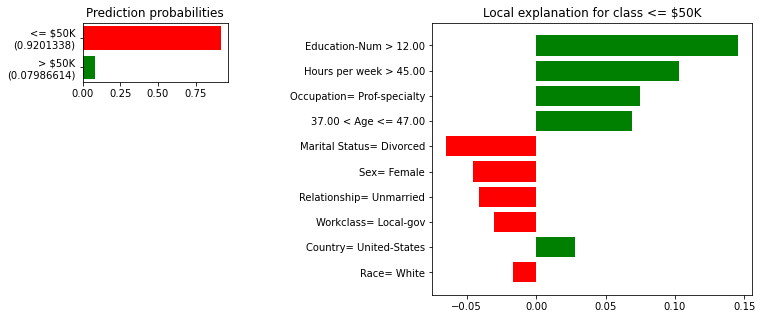

<Figure size 432x288 with 0 Axes>

In [15]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.

***

<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<h3>Post-modelling Explainability - Prediction - Verbal Explaination:</h3>
<p style="fontsize:80px">

Definitions:  
    <br>
The right plot is Global Interpretation and left plot is Local Interpretation. Red color is for class <= $\$50$K and green color is for class income  >$\$50$K.   
                                                                                                          <br>  
    <br>  
Interpretation:  
    <br>
As we can see from the prediction that individual at index 2 in test dataset was actually an individual with salary <= $\$50$K and was predicted correctly. The probability of individual being >$\$50$K was 0.07986614 where as probability of individual being <=$\$50$K was 0.9201338. As per black box model explaination provided by LIME, the drivers that led model to predict <=$\$50$K outcome were features with red bars in Local Interpretation i.e Marital Status = Divorced, Sex = Female, Relationship = Unmarried, Race = White, Workclass = Local-gov. However, features in green bars were drivers for predicting >$\$50$K outcome but only accounted for 0.07986614 of total probability.  

</p>
</div>

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [16]:
instanceModified1 = X_test.iloc[i]
print(instanceModified1)
instanceModified1['Marital Status'] = 6
instanceModified1['Sex'] = 1
print(instanceModified1)

Age               43.0
Workclass          2.0
Education-Num     13.0
Marital Status     0.0
Occupation        10.0
Relationship       4.0
Race               4.0
Sex                0.0
Hours per week    48.0
Country           39.0
Name: 3474, dtype: float32
Age               43.0
Workclass          2.0
Education-Num     13.0
Marital Status     6.0
Occupation        10.0
Relationship       4.0
Race               4.0
Sex                1.0
Hours per week    48.0
Country           39.0
Name: 3474, dtype: float32


Intercept 0.01628865075085094
Prediction_local [0.39680345]
Right: 0.75135845


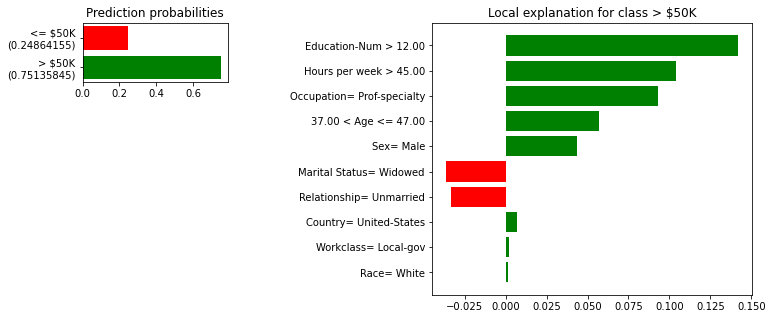

<Figure size 432x288 with 0 Axes>

In [17]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?





<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<p style="fontsize:80px">
As we can see from above LIME explaination, changing values of features Marital Status and Sex for individual 2 changed the prediction of model from <=$\$50$K to >$\$50$K for that individual.    
    <br>    
    <br>                                                                                                            
Reason Behind Choosing Features -  Marital Status and Sex:  
    <br> 
From LIME explaination plot of Task 3 we can see that individual 2 was originally classified as having income <=$\$50$K with probability of  0.9201338 and fearues Marital Status = Divorced and Sex = Female accounted for most part of the probability (ref to red bars). This tells us that fearues Marital Status and Sex were most important drivers behind this prediction. Hence, changing their values might change the model Prediction.  
    <br>  
    <br>
Now, that we know changing values of Marital Status and Sex might change the prediction of model for individual 2, we must experiment with combination of possible values of each feature. Below are the possible values.  
    <br>
- Marital Status: {0: ' Divorced', 1: ' Married-AF-spouse', 2: ' Married-civ-spouse', 3: ' Married-spouse-absent', 4: ' Never-married', 5: ' Separated', 6: ' Widowed'}  
    <br>
- Sex': {0: ' Female', 1: ' Male'}  
    <br>
By experimenting with multiple possible combinations, it was found that Marital Status = Widowed and Sex = Male changed the prediction of model for individual 2 from <=$\$50$K to >$\$50$K (P = 0.7513)


</p>
</div>

## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [18]:
a = np.where(predictions == 1)
b = np.where(y_test == 1)
np.intersect1d(a,b)

# Change only the value of to select that person:
j = 12
###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")


Intercept 0.03496191289164059
Prediction_local [0.34165803]
Right: 0.71684
********************
Test id:  12
Probability( <= $50K ) = 0.28315997
Probability( > $50K ) = 0.71684
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


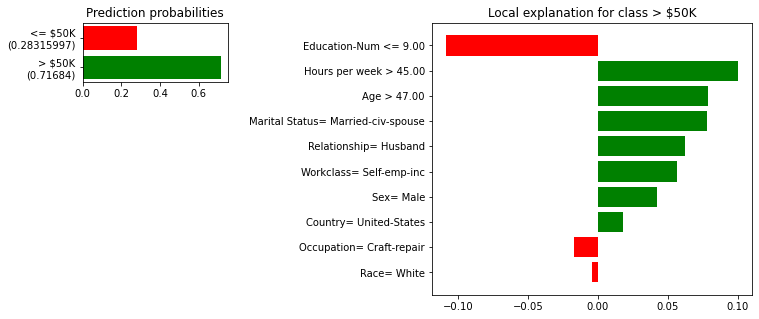

<Figure size 432x288 with 0 Axes>

In [19]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.

***

<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<h3>Post-modelling Explainability - Prediction - Verbal Explaination:</h3>
<p style="fontsize:80px">

Interpretation:  
    <br>
As we can see from the prediction that individual at index 12 in test dataset was actually an individual with salary >$\$50$K and was predicted correctly. The probability of individual being >$\$50$K was 0.7168 where as probability of individual being <=$\$50$K was 0.2831. As per black box model explaination provided by LIME, the drivers that led model to predict >$\$50$K outcome were features with green bars in Local Interpretation i.e Hours per week > 45, Age > 47, Marital Status = Married-civ-spouse, Relationship = Husband, Workclass = self-emp-inc, Sex = Male. However, features in red bars were drivers for predicting <=$\$50$K outcome but only accounted for 0.2831 of total probability.  

</p>
</div>

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [20]:
instanceModified2 = X_test.iloc[j]
instanceModified2['Hours per week'] = 35
instanceModified2['Age'] = 25
print(instanceModified2)

Age               25.0
Workclass          5.0
Education-Num      9.0
Marital Status     2.0
Occupation         3.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    35.0
Country           39.0
Name: 32462, dtype: float32


Intercept 0.20553106351601313
Prediction_local [0.06193188]
Right: 0.11769972


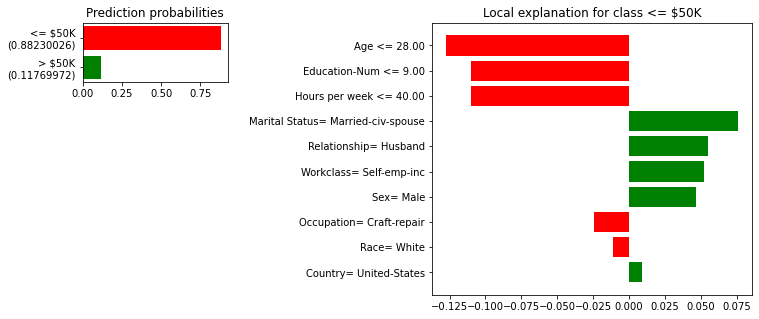

<Figure size 432x288 with 0 Axes>

In [21]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?





<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<p style="fontsize:80px">
As we can see from above LIME explaination, changing values of features Hours per week and Age for individual 12 changed the prediction of model from >$\$50$K to <=$\$50$K for that individual.  
    <br>  
    <br>                                                                                                           
Reason Behind Choosing Features -  Hours per week and Age:  
    <br>     
From LIME explaination plot of Task 7 we can see that individual 12 was originally classified as having income >$\$50$K with probability of  0.7168 and fearues Hours per week > 45 and Age > 47 accounted for most part of the probability (ref to green bars). This tells us that Hours per week and Age were most important drivers behind this prediction. Hence, changing their values might change the model Prediction.  
    <br>  
    <br>  
Now, that we know changing values of Hours per week and Age might change the prediction of model for individual 12, we must experiment with combination of possible values of each feature. With pragmatic thought and real world facts we can approximate that if person works for more hours, it is possible that he/she might earn more (not always true; subject to type of work) and person in elder age group earns more compared to person in younger age group (not always true; subject to type of work and position). Even though this thesis fails for certain scenarios, we get rough idea that reducing individual 12's working hours and age might change prediction of the model.  
     <br> 
By experimenting with multiple values for these two features, it was found that Hours per week = 35 (any value < 40) and Age = 25 (any value < 28) changed the prediction of model for individual 12 from >$\$50$K to <=$\$50$K (P = 0.8823)


</p>
</div>

# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [22]:
a = np.where(predictions == 0)
b = np.where(y_test == 1)
np.intersect1d(a,b)

# Change only the value of to select that person:
k = 26
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept 0.15099568032152
Prediction_local [0.14328984]
Right: 0.32984498
********************
Test id:  26
Probability( <= $50K ) = 0.67015505
Probability( > $50K ) = 0.32984498
Predicted Label: 0
True class:  1
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


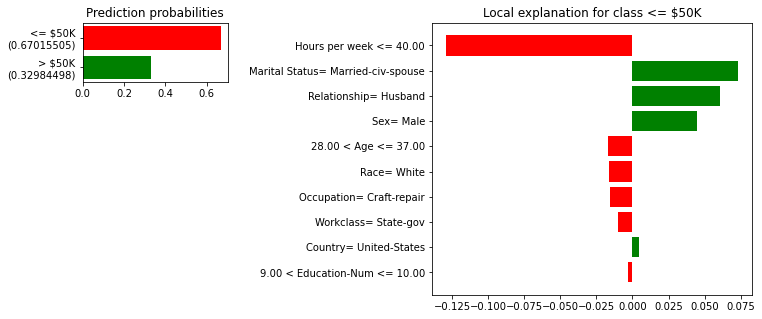

<Figure size 432x288 with 0 Axes>

In [23]:
plot_explanation(exp3, mapping)


***

**Task 12**: Please provide comments on the above explanation provided by LIME.

***

<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<h3>Post-modelling Explainability - Prediction - Verbal Explaination:</h3>
<p style="fontsize:80px">

Interpretation:  
    <br>
As we can see from the prediction that individual at index 26 in test dataset was actually an individual with salary >$\$50$K but was predicted incorrectly as having salary <=$\$50$K. The probability of individual being >$\$50$K was 0.3298 where as probability of individual being <=$\$50$K was 0.6701. As per black box model explaination provided by LIME, the drivers that led model to predict <=$\$50$K outcome were features with red bars in Local Interpretation i.e Hours per week <= 40, Age between 28 & 37, Occupation = Craft-repair, Race = White, Workclass = State-gov. However, from observing results for all the tasks above it looks like our algorithm gives most importance to Hours per week feature in determining class. The features in green bars were drivers for predicting >$\$50$K outcome but only accounted for 0.3298 of total probability.  

</p>
</div>

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [24]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Hours per week'] = 45
instanceModified3['Age'] = 48
print(instanceModified3)

Age               48.0
Workclass          7.0
Education-Num     10.0
Marital Status     2.0
Occupation         3.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    45.0
Country           39.0
Name: 14628, dtype: float32


Intercept 0.026192592344705237
Prediction_local [0.33742722]
Right: 0.77555317


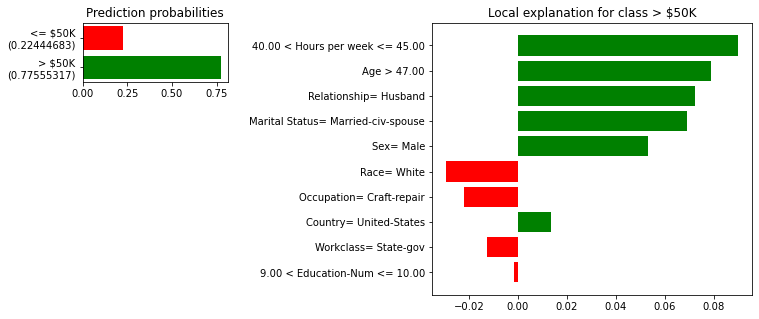

<Figure size 432x288 with 0 Axes>

In [25]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?





<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<p style="fontsize:80px">
As we can see from above LIME explaination, changing values of features Hours per week and Age for individual 26 changed the prediction of model from <=$\$50$K to >$\$50$K for that individual.  
     <br>  
    <br>                                                                                                            
Reason Behind Choosing Features -  Hours per week and Age:  
    <br>     
From LIME explaination plot of Task 11 we can see that individual 26 was originally classified as having income <=$\$50$K with probability of  0.6701 and fearues Hours per week < 40, Occupation = Craft-repair and Age in between 28 to 37 accounted for most part of the probability (ref to red bars). Along with this all the task from Task 3 to 11 tells us that Hours per week and Age were most important drivers behind predicting class. Hence, changing their values might change the model Prediction.  
    <br>  
    <br>  
Now, that we know changing values of Hours per week and Age might change the prediction of model for individual 12, we must experiment with combination of possible values of each feature. With pragmatic thought and real world facts we can approximate that if person works for more hours, it is possible that he/she might earn more (not always true; subject to type of work) and person in elder age group earns more compared to person in younger age group (not always true; subject to type of work and position). Even though this thesis fails for certain scenarios, we get rough idea that increasing individual 26's working hours and age might change prediction of the model.  
    <br> 
By experimenting with multiple values for these two features, it was found that Hours per week = 45 (any value > 40) and Age = 48 (any value > 40) changed the prediction of model for individual 26 from <=$\$50$K to >$\$50$K (P = 0.7755)


</p>
</div>

# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [26]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [27]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [28]:
report = classification_report(y_test, predictions)
print(report)
from sklearn.metrics import f1_score
f1_score(y_test, predictions, average='weighted')

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



0.8032133100633859

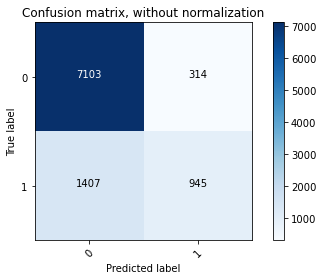

In [29]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

***
**Task 15**:  Please provide comments on the performance of the decision Tree.


<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<h3>Post-modelling Explainability - Performance - Verbal Explaination:</h3>
<p style="fontsize:80px">

<br>
Definitions:  
<br>
Confusion Matrix - Confusion matrix is a 2D table of prediction counts of true class labels vs predicted class labels.  <br>

|  | Actual Positive | Actual Negative |
| --------- | ----------- | -------- |
| Predicted Positive | True Positive(TP) | False Positive(FP) |
| Predicted Negative | False Negative(FN) | True Negative(TN) |

  <br>
Accuracy Score - TP+TN / (TP+TN+FP+FN)  
    <br>
Precision - TP / TP+FP  
    <br>
Recall - TP / TP+FN  
    <br>
F1 - 2 * (Precision * recall) / Precision + recall  
    <br>
  <br>  
Interpretation:  
    <br>
- As per the confusion matrix, 8048 records were classified correctly and 1721 records were misclassified.  <br>
- According to classification report, accuracy achieved by classifier was 82.00 %. However, as we see from statistical plot in preprocessing section that classes in our dataset are highly imbalanced. We cannot count on accuracy score alone for judging performance of the model. We also need to take into consideration precision and recall scores. F1 score is harmonic mean of precision and recall and gives equal importance to both. F1 score for Decision Tree classifier trained above is 80.32 %.  
    <br>  
    <br>    
Compared to XGBoost Classifier:  
    <br>
Comparing the performance of Decision Tree Classifier with XGBoost Classifier we see that XGBoost acheived higher accuracy of 83% and F1 Score 83%. This is beacuase Decision Tree classifier uses only one tree for prediction while XGBoost uses ensemble of multiple decision trees with gradient boosting technique.  
    <br>  
    <br>  
The performance of the model can be further improved by implementing following things:  
    <br>
1. In preprocessing use OneHotEncoding (binary) rather than LabelEncoding(integers) as integer encoding has sequence which might mislead model  
    <br>
2. Standardize / Normalize the data.  
    <br>
3. Tune hyperparameters of the Decision Tree classifier.  
    <br>
    
    

</p>
</div>

# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [30]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, filled=True, rounded=True, impurity= False)

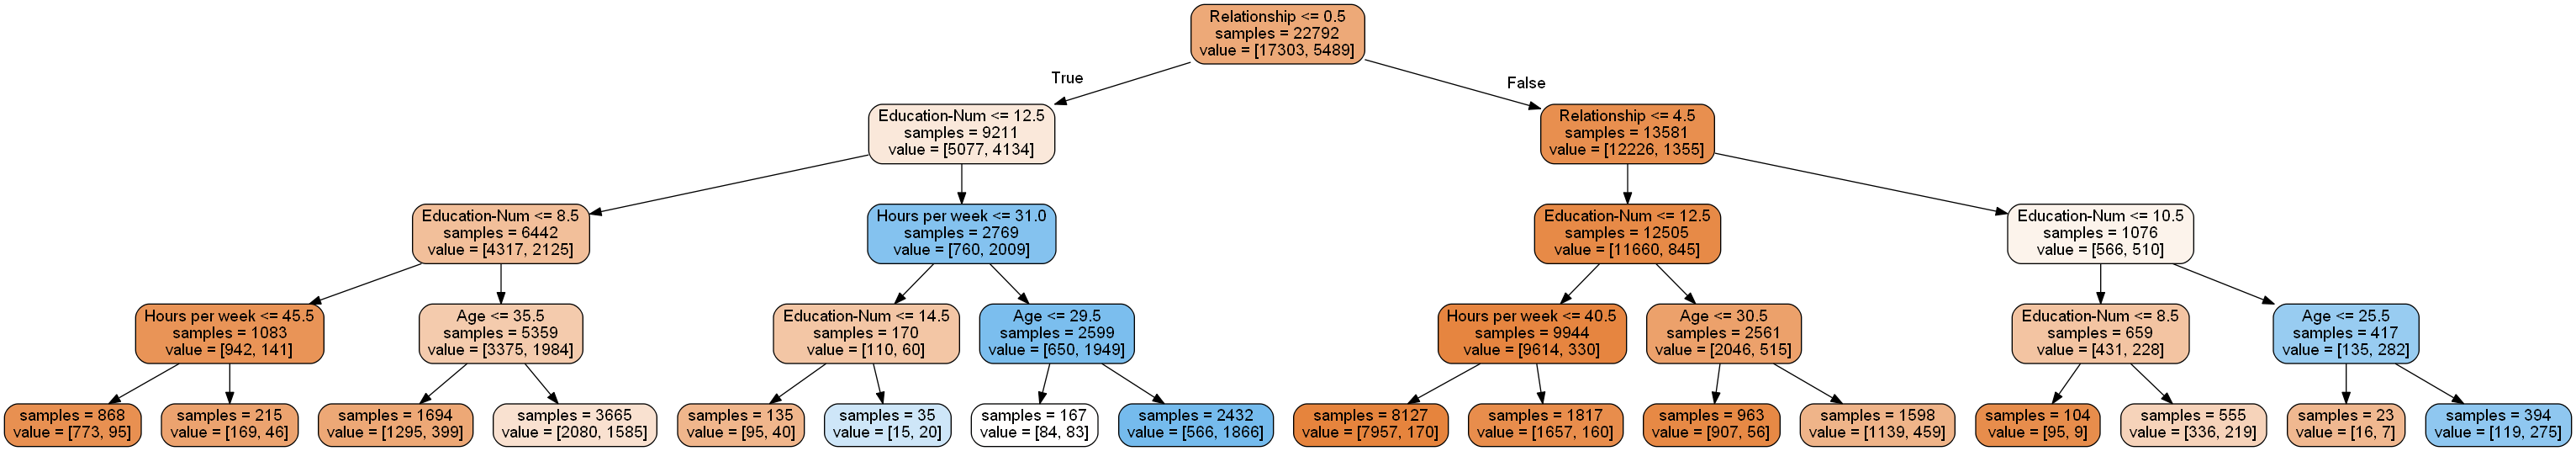

In [31]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors). 


<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<p style="fontsize:80px">
Graphviz - It is a open source library which provides graphical visualization in this case viasualization of decision tree.  <br> 
Decision Tree - All the rectangular boxes are nodes. The very first node is called as Root Node, the lowest nodes are called as leaf nodes as they are not further split. Nodes at each level in the tree are child nodes of nodes just above them (except root node). Nodes at each level in the tree are parent nodes of nodes just below them (except leaf nodes).  
    <br>  
    <br>  
Interpretation:  
    <br>
The above graph shows graphical visualization of decision process that our decision tree classifier followed to predict whether individual belongs to class <=$\$50$K or >$\$50$K. It is a Global Interpretation of the model. Each node in the tree is displaying 3 properties: 'Condition' - It is condition based on value of particular feature in the dataset used for further spliting of the node. If condition is satisfied (True), go left and if condition is not satisfied (False), go right  ; 'Samples' - It is number of samples that node contains and further splits them into the child node based on condition. Root node contains all the samples in the dataset ; 'Value' - It is number of samples belonging to class based on condition of the node. It is also probability of classes in leaf nodes. Here nodes have two values because we have two classes 0 (<=$\$50$K) and 1 (>$\$50$K).  
    <br>  
    <br>  
1. Color of Nodes: In decision tree graph above, we can see nodes have different colors. Nodes either have dark blue, dark orange or lighter shades of blue and orange. The color of the node is based on 'Value' property. Value property has two parts: first belongs to class 0 and second belongs to class 1. Value is nothing but part of total number of sample of that node belonging to classes, in other words probability. Node has orange color if its probability of being class 0 (<=$\$50$K) is more than that of class 1 (>$\$50$K) based on 'Value'. Node has blue color if its probability of being class 1 (>$\$50$K) is more than that of class 0 (<=$\$50$K) based on 'Value'. Greater the probability, darker the color gets (orange/blue)  
    <br>  
    <br>
2. Root Node: It has 22792 samples (entire dataset). Our classifier gave first priority to Relationship feature as it must have highest information gain for decision making. Based on relationship value root node is further split into two child nodes. If value of relationship is <= 0.5, left path is selected. If value of relationship is > 0.5, right path is selected.If we see Value property of root node, 17303 samples classified as class 0 and 5489 classified as class 1 i.e at this level probability of individual being class 0 is 17303 / (17303+5489) and  probability of individual being class 1 is 5489 / (17303+5489).  
    <br>  
    <br>
3. Child Nodes: Same principle is applied to child nodes. If 'condition' is satisfied algorithm takes left path and if 'condition' is not satisfied it takes right path.  <br>  
    <br>  
4. Leaf Nodes: The child nodes are further split until algorithm reaches node that can't be further split and is enough to decide class of individual record. Based on score in 'Value' property or color (orange / blue irrespective of shades) for that matter, leaf node decides whether individual belongs to class 0 (<=$\$50$K) or 1 (>$\$50$K). 
</p>
</div>

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [32]:
# Change only the value of to select that person:
h = 12
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")


Intercept 0.14172501611689814
Prediction_local [0.3188629]
Right: 0.4324693042291951
********************
Test id:  12
Probability( <= $50K ) = 0.567530695770805
Probability( > $50K ) = 0.4324693042291951
Predicted Label: 0
True class:  1
********************


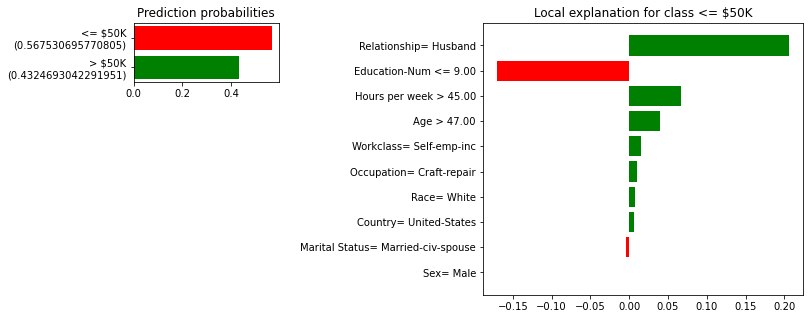

<Figure size 432x288 with 0 Axes>

In [33]:
plot_explanation(exp4, mapping)

***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.


<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<p style="fontsize:80px">
The above LIME explanation is for individual 12 who actually belongs to class 1 (>$\$50$K) but is incorrectly classified belonging to class 0 (<=$\$50$K) with probability 0.5675. According to the local LIME explanation, we can see that most important drivers behind this prediction were Education-Num <=9 and Sex = Male. However, if you refer to the decision tree graph to determine how model decided on this outcome, we see that model took the path as 1.Root node condition True, go left 2. second child node condition True, go left 3. 3rd child node condition False, go right 4. 4th child node condition False, go right and we finally reach to leaf node which has 'Value' for class 0 (2080) greater than that of class 1(1585) and is of color light orange. Thus, based on decision tree, our model incorrctly predicted class for individual 12 as <=$\$50$K. 
</p>
</div>

# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

In [43]:
import pandas as pd
df = pd.DataFrame(columns=['Age', 'Workclass','Education-Num','Marital Status','Occupation','Relationship','Race','Sex','Hours per week','Country'])
df = df.append({'Age':48.0, 'Workclass':5.0,'Education-Num':13.0,'Marital Status':2.0,'Occupation':3.0,'Relationship':0.0,'Race':4.0,'Sex':1.0,'Hours per week':45.0,'Country':39.0},ignore_index = True)
print(df)

Intercept 0.06992570992956773
Prediction_local [0.52604026]
Right: 0.7672697368421053


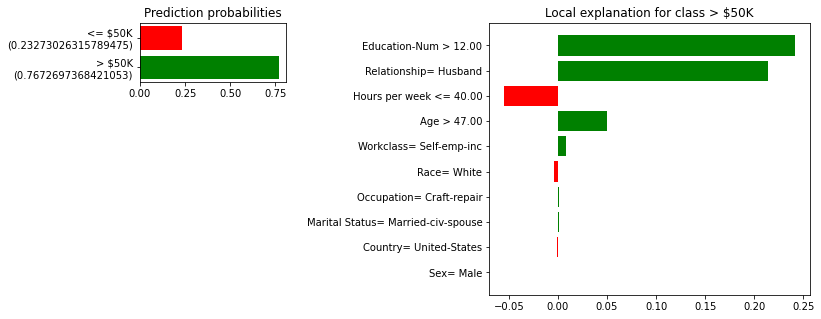

<Figure size 432x288 with 0 Axes>

In [45]:
exp = explainer.explain_instance(df.iloc[0].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(df.iloc[0].values))
plot_explanation(exp, mapping)

<div style="background-color:#34495E;color:#F8F9F9"  class="alert alert-block alert-info">
<p style="fontsize:80px">
In the above task we added a new individual with following features: <br>


| Feature | Value | 
|---|---|
| Age          |    48.0|
|Workclass     |    Self-emp-inc|
|Education-Num |   13.0|
|Marital Status|    Married-civ-spouse|
|Occupation    |    Craft-repair|
|Relationship  |    Husband|
|Race          |    White|
|Sex           |    Male|
|Hours per week|   45.0|
|Country       |   United-States|
<br>

As per task instruction, this individual is supposed to be classified as '>$\$50$K'. The feature values for this individual were selected referring to decision tree graph from task 16. According to this graph if we keep value of Relationship <=0.5, Education-Num > 12.5, Hours per week > 31, Age > 29.5, this individual will be classified as having income '>$\$50$K' irrespective of other features. Consequently, this individual was correctly classified by our Decision Tree classifier as having income '>$\$50$K' with probability of 0.7672 (ref to LIME Global Interpretation). As per LIME local interpretation, main drivers behind this prediction were Education-Num, Relationship, Age and workclass. These are same attributes that decision tree in task 16 shows for making decision for this individual.
 
</p>
</div>

# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

